Initialise  
Mid price - classification rather than, 
Label - neural network (Random Forest)
mid-price

In [2]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import glob

Import data

In [22]:
# path where months data is saved
path = r'C:\Users\timot\Documents\Bristol Uni\006 - Data Science Mini Projects\003 - ARIMA Model\ARIMA-Model\Month Prediction\Month Data\January\*.csv' 
all_files = glob.glob(path)

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

data = pd.concat(li, axis=0, ignore_index=True)

#print(frame.head(15))
print(data.head(15))
print(data.tail(15))

        Time          Bid1         Bid2          Ask1          Ask2  \
0   07:30:00      [1.0, 6]       [0, 0]        [0, 0]        [0, 0]   
1   07:30:01    [27.0, 20]    [1.0, 12]    [798.4, 5]        [0, 0]   
2   07:30:02   [261.75, 8]   [21.0, 13]  [306.46, 13]   [403.57, 7]   
3   07:30:03  [262.75, 48]   [261.0, 8]  [292.56, 16]  [294.59, 32]   
4   07:30:04   [264.0, 36]   [261.0, 6]  [287.45, 20]   [288.1, 21]   
5   07:30:05   [264.0, 36]   [261.0, 6]  [283.17, 30]   [285.0, 10]   
6   07:30:06  [265.17, 36]   [261.0, 6]  [282.36, 11]  [283.06, 18]   
7   07:30:07   [266.0, 36]   [261.0, 6]  [280.27, 11]  [280.88, 16]   
8   07:30:08   [266.0, 36]   [261.0, 6]  [276.57, 14]  [277.19, 21]   
9   07:30:09  [266.31, 78]  [261.0, 13]  [271.36, 25]  [272.14, 37]   
10  07:30:10   [267.0, 35]   [261.0, 6]   [269.33, 6]  [270.86, 22]   
11  07:30:11   [267.0, 44]  [261.0, 12]  [270.25, 52]  [273.18, 45]   
12  07:30:12   [267.0, 21]  [261.86, 7]   [270.0, 25]   [273.0, 21]   
13  07

Do ADF Test to check if data is stationary 

In [4]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['Mid-Price'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation
if result[0] < result[4]["5%"]:
    print("Reject the null hypothesis - Data is stationary")
else:
    print("Fail to reject the null hypothesis - Data is not stationary")

ADF Statistic: -17.184787
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Reject the null hypothesis - Data is stationary


Plot ACF

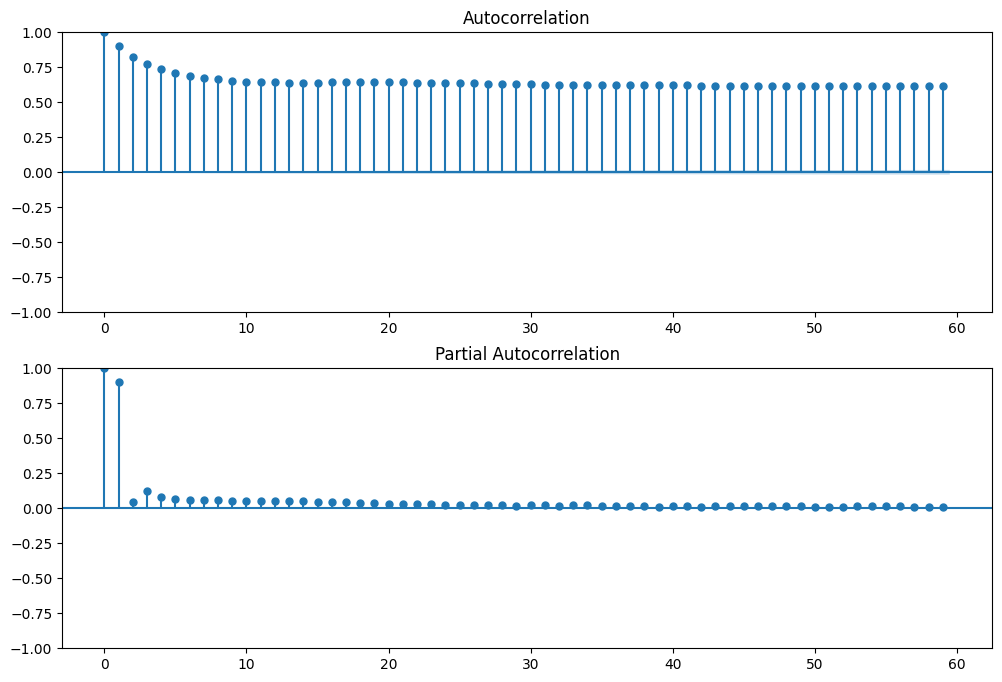

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Selecting the 'Mid-Price' column for ACF and PACF plots
train_mid_price = data['Mid-Price']

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(train_mid_price, ax=ax[0])  # ACF plot for 'Mid-Price'
plot_pacf(train_mid_price, ax=ax[1])  # PACF plot for 'Mid-Price'

plt.show()

Use pdarima package to check d calc

In [21]:
from pmdarima.arima.utils import ndiffs 

ndiffs(data['Mid-Price'], test = "adf")

0

Plot interpretation

ACF Plot Interpretation:

The ACF plot tails off gradually, which indicates that the data may be either an AR process or a mixed ARMA process. In an ACF plot for a pure MA process, we would expect a sharp cut-off after the significant lags. Therefore p = 1.

PACF Plot Interpretation:

The PACF plot shows a significant spike at lag 1, and then it almost immediately cuts off (becomes insignificant). Given the lack of significant spikes in the ACF plot beyond the immediate lag, I will start with q=0 and test q=1 as well.

Differencing Term (d):

As per the ADF test, the data is stationary so d = 0




Do ARIMA Test

In [15]:
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model
model = ARIMA(data['Mid-Price'], order=(1, 0, 1))  # Example order, adjust as necessary
arima_fit = model.fit()
# Summary of the model
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Mid-Price   No. Observations:               673170
Model:                 ARIMA(1, 0, 1)   Log Likelihood            -2686493.639
Date:                Wed, 06 Mar 2024   AIC                        5372995.277
Time:                        21:52:22   BIC                        5373040.956
Sample:                             0   HQIC                       5373008.051
                             - 673170                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        324.6939      0.205   1582.644      0.000     324.292     325.096
ar.L1          0.9163      0.000   2858.542      0.000       0.916       0.917
ma.L1         -0.0705      0.000   -177.454      0.0

Forecast the test set


In [17]:
# Import the real data
real = pd.read_csv('UoB_Set01_2025-02-03LOBs.csv')
print(real.head())

# Forecast the length of the test values
arima_predicted = arima_fit.forecast(steps=len(real['Time']))
predicted = arima_predicted.to_frame(name='Mid-Price')

# Reset the index of the predicted DataFrame to ensure alignment
predicted.reset_index(drop=True, inplace=True)

#predicted.insert(0, 'Time', real['Time'])
predicted['Time'] = real['Time']

print(type(predicted))
print(predicted)

       Time          Bid1          Bid2          Ask1          Ask2  \
0  07:30:00    [202.0, 4]        [0, 0]        [0, 0]        [0, 0]   
1  07:30:01    [202.0, 4]        [0, 0]    [354.0, 5]        [0, 0]   
2  07:30:02    [202.0, 8]        [0, 0]    [333.0, 6]   [353.83, 6]   
3  07:30:04  [207.53, 15]   [202.6, 10]    [295.0, 8]  [323.75, 20]   
4  07:30:05  [216.41, 17]  [212.13, 23]  [293.91, 23]   [301.0, 23]   

   Mid-Price  Total_volume  Bid_ask_spread  Order_imbalance  
0     101.00             4         -202.00             1.00  
1     278.00             9          152.00            -0.11  
2     267.50            20          131.00            -0.20  
3     251.27            53           87.47            -0.06  
4     255.16            86           77.50            -0.07  
<class 'pandas.core.frame.DataFrame'>
        Mid-Price      Time
0      324.760851  07:30:00
1      324.755253  07:30:01
2      324.750124  07:30:02
3      324.745424  07:30:04
4      324.741117  07:3

Plot the predicted against the test

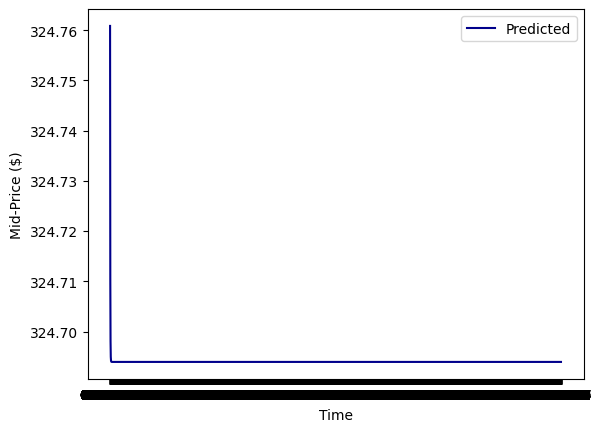

In [21]:
#plt.plot(train['Time'], train['Mid-Price'], label = 'Train')
plt.plot(predicted['Time'], predicted['Mid-Price'], color = 'darkblue', label = 'Predicted')
#plt.plot(real['Time'], real['Mid-Price'], color = 'orange', label = 'Real')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Mid-Price ($)')
plt.show()

In [19]:
print(real['Mid-Price'])
print(predicted['Mid-Price'])

0        101.00
1        278.00
2        267.50
3        251.27
4        255.16
          ...  
30594    356.31
30595    394.10
30596    402.20
30597    368.50
30598    366.86
Name: Mid-Price, Length: 30599, dtype: float64
0        324.760851
1        324.755253
2        324.750124
3        324.745424
4        324.741117
            ...    
30594    324.693949
30595    324.693949
30596    324.693949
30597    324.693949
30598    324.693949
Name: Mid-Price, Length: 30599, dtype: float64


Error Measurements

In [26]:
# Mean Absolute Error
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test['Mid-Price'], predicted['Mid-Price'])
print("Mean Absolute Error (MAE):", mae)

# Mean Squared Error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test['Mid-Price'], predicted['Mid-Price'])
print("Mean Squared Error (MSE):", mse)

# Root Mean Squared Error
rmse = mean_squared_error(test['Mid-Price'], predicted['Mid-Price'], squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

# R-squared
from sklearn.metrics import r2_score
r2 = r2_score(test['Mid-Price'], predicted['Mid-Price'])
print("R-squared:", r2)

Mean Absolute Error (MAE): 20.694582059757856
Mean Squared Error (MSE): 756.8680518694753
Root Mean Squared Error (RMSE): 27.51123501170886
R-squared: -0.09924785547627835


c:\Users\timot\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean Absolute Error (MAE): 10.306754469224506

The MAE tells you that, on average, your model's predictions are about 10.31 units away from the actual values. This is a direct measure of how accurate your model is, without considering the direction of the errors.


Mean Squared Error (MSE): 401.32652005997784

The MSE significantly higher than the MAE suggests that there are instances where the model's predictions are quite far from the actual values. This metric is sensitive to outliers, indicating your predictions might have some substantial errors in certain cases.


Root Mean Squared Error (RMSE): 20.03313555237866

The RMSE, like the MSE, is affected by outliers and large errors, and provides a sense of the average magnitude of the errors in the same units as your target variable. An RMSE of 20.03 means that the standard deviation of the prediction errors is around 20.03 units. 
This gives you an idea of the spread of the errors around the mean error (MAE).

R-squared: -0.19216190799522415

An R-squared value below 0 suggests that the model performs worse than a simple horizontal line representing the mean of the dependent variable. This negative value indicates that your model may not have captured any of the underlying trends in the data and is not explaining the variance in your target variable effectively.


Overall Interpretation:
The MAE and RMSE values indicate that the model has room for improvement in terms of accuracy. The large gap between MAE and RMSE suggests the presence of significant outliers or predictions far from the actual values.

The negative R-squared value is particularly concerning as it indicates the model's predictions do not align well with the actual data. It suggests that the model, in its current form, might not be suitable for your data or that the features you're using are not good predictors of the target variable.


Recommendations:
Review Model Features: Consider whether additional features or different representations of your current features could improve model performance.
Outlier Analysis: Examine your data for outliers that could be disproportionately influencing the model's errors.
Model Complexity: If your model is too simple, it might not capture complex patterns in the data. Conversely, if it's too complex, it might be overfitting. Adjusting model complexity could be a way to improve performance.
Cross-Validation: Use cross-validation to ensure that your model's performance is consistent across different subsets of your data.
Alternative Models: Explore different modeling techniques that might be more suited to your data's characteristics.

Thresholds - Standard Deviation

In [43]:
clean_data = data[data['Mid-Price'] > 0]

# Calculate the mean and standard deviation of the mid-price
mean_mid_price = clean_data['Mid-Price'].mean()
std_dev_mid_price = clean_data['Mid-Price'].std()

# Determine the thresholds based on a multiple of the standard deviation from the mean mid-price
# Typically, thresholds are set at mean +/- n * standard deviation (where n can be 1, 2, or 3)
n = 1 # This is a common choice for a threshold, but can be adjusted based on backtesting
lower_threshold = mean_mid_price - n * std_dev_mid_price
upper_threshold = mean_mid_price + n * std_dev_mid_price

mean_mid_price, std_dev_mid_price, lower_threshold, upper_threshold

(315.2998084842146, 21.944189555100383, 293.35561892911426, 337.243998039315)

Mid-Price Buy Signal df

In [45]:
mid_price_sig = pd.DataFrame()
mid_price_sig['Predicted Train Time'] = predicted['Time']
mid_price_sig['Predicted Mid-Price'] = predicted['Mid-Price']

# make a function to get the buy/sell signal
def determine_trade_action(price, lower_threshold, upper_threshold):
    if price > upper_threshold:
        return 'Sell'
    elif price < lower_threshold:
        return 'Buy'
    else:
        return 'Hold'

mid_price_sig['Buy/Sell'] = mid_price_sig['Predicted Mid-Price'].apply(determine_trade_action, args=(lower_threshold, upper_threshold))

mid_price_sig.to_csv('ARIMA Mid-Price Signal.csv', index=False)

Look at doing thresholds or tighter std

In [48]:
# Since the state has been reset, we need to re-import the data and re-calculate the mean and std deviation
# Define the function to determine the trade action
def determine_trade_action(price, lower_threshold, upper_threshold):
    if price > upper_threshold:
        return 'Sell'
    elif price < lower_threshold:
        return 'Buy'
    else:
        return 'Hold'

# Clean the data by removing entries with a mid-price of 0
clean_data = data[data['Mid-Price'] > 0]

# Calculate the mean and standard deviation of the mid-price from the historical data
mean_mid_price = clean_data['Mid-Price'].mean()
std_dev_mid_price = clean_data['Mid-Price'].std()

# Now, we will calculate alternative thresholds based on the percentiles of the historical mid-prices
# This will help us to set thresholds that are more aligned with the actual data distribution
percentiles = [0.05, 0.95]  # 10th and 90th percentiles for lower and upper thresholds respectively
lower_threshold_percentile = clean_data['Mid-Price'].quantile(percentiles[0])
upper_threshold_percentile = clean_data['Mid-Price'].quantile(percentiles[1])

# Load the predicted data to check how it fits with these thresholds
predicted_data = mid_price_sig

# Apply the trade action function to the predicted data using the new percentile-based thresholds
predicted_data['Trade_Action_Percentile'] = predicted_data['Predicted Mid-Price'].apply(
    determine_trade_action, args=(lower_threshold_percentile, upper_threshold_percentile))

# Calculate the alternative thresholds based on a tighter standard deviation multiplier
# We will use a smaller multiplier to see if the predicted values cross these new thresholds
tighter_multiplier = 1  # This can be adjusted as needed
lower_threshold_tighter = mean_mid_price - tighter_multiplier * std_dev_mid_price
upper_threshold_tighter = mean_mid_price + tighter_multiplier * std_dev_mid_price

# Apply the trade action function to the predicted data using the new tighter std dev thresholds
predicted_data['Trade_Action_Tighter'] = predicted_data['Predicted Mid-Price'].apply(
    determine_trade_action, args=(lower_threshold_tighter, upper_threshold_tighter))

# Output the thresholds and the first few rows of the predicted data to see the trade actions
(lower_threshold_percentile, upper_threshold_percentile), (lower_threshold_tighter, upper_threshold_tighter), predicted_data.head()


predicted_data.to_csv('predicted_data.csv')

296.5